# Unsupervised Learning Primer

This chapter is heavily based on the chapter "K-Means Clustering" of "Programming Collective Intelligence" by Toby Segaran.


## Imports and setup

In [1]:
import os
import sys

sys.path.append(os.getcwd())
import matplotlib.pyplot as plt
import numpy as np
import data_utils

%matplotlib inline

In [2]:
df_movies = data_utils.load_dataset_from_local("tmdb_5000_movies.csv.zip")[
    [
        "id",
        "title",
        "budget",
        "revenue",
        "runtime",
        "popularity",
        "vote_average",
    ]
]
df_movies = df_movies.loc[
    (df_movies["budget"] > 0) & (df_movies["revenue"] > 0) & (df_movies["runtime"] > 0)
].copy()
df_movies

,id,title,budget,revenue,runtime,popularity,vote_average
0,19995,Avatar,237000000,2787965087,162.0,150.437577,7.2
1,285,Pirates of the Caribbean: At World's End,300000000,961000000,169.0,139.082615,6.9
2,206647,Spectre,245000000,880674609,148.0,107.376788,6.3
3,49026,The Dark Knight Rises,250000000,1084939099,165.0,112.312950,7.6
4,49529,John Carter,260000000,284139100,132.0,43.926995,6.1
...,...,...,...,...,...,...,...
4773,2292,Clerks,27000,3151130,92.0,19.748658,7.4
4788,692,Pink Flamingos,12000,6000000,93.0,4.553644,6.2
4792,36095,Cure,20000,99000,111.0,0.212443,7.4
4796,14337,Primer,7000,424760,77.0,23.307949,6.9


## Clustering items

Clustering is a process in which we group a set of objects in such a way that objects in the same group (called a cluster) are more similar to each other than to those in other groups. There are many clustering algorithms, such as K-means, DBSCAN, hierarchical clustering, etc. In this chapter, we will focus on the K-means algorithm. The `K-means` algorithm is one of the simplest and most commonly used clustering algorithms. It tries to partition the dataset into `K` pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different as possible.  



Eventually, we will use the data above for the clustering, but first, let's examine a simpler example.

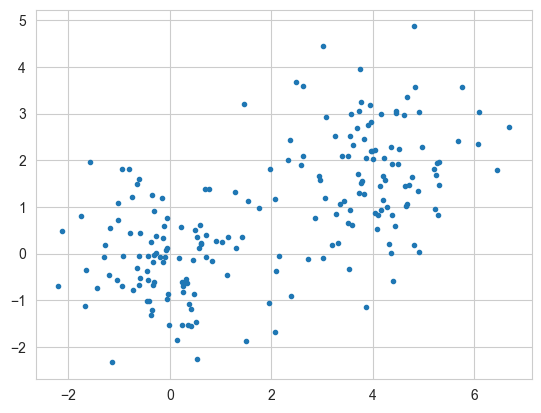

In [3]:
np.random.seed(111)
true_center_1 = (0, 0)
true_center_2 = (4, 2)
x = np.concatenate(
    [
        np.random.normal(true_center_1[0], 1, 100),
        np.random.normal(true_center_2[0], 1, 100),
    ]
)
y = np.concatenate(
    [
        np.random.normal(true_center_1[1], 1, 100),
        np.random.normal(true_center_2[1], 1, 100),
    ]
)
plt.plot(x, y, ".")

The data above is a mix of two distributions. Let's apply K-means clustering to it.

We don't have to be super smart to guess that the data above is composed of two clusters, so `K=2` is a good choice for the number of clusters in this case. Later on, we will see how to choose the number of clusters in a more complex case.

The K-means algorithm works as follows:
- Randomly initialize `K` cluster centers
- Assign each point to the nearest cluster center
- Recalculate cluster centers
- Repeat until convergence


The key, the most important word, in the description above is "nearest". It is important because it implies that we need to define a distance metric. There are many distance metrics such as Euclidean, Manhattan, Minkowski, etc. In this case, we will use the Euclidean distance. Select the wrong metric, and you get garbage.

In [4]:
rows = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

In [5]:
k = 2
ranges = [
    (min([row[i] for row in rows]), max([row[i] for row in rows]))
    for i in range(len(rows[0]))
]
ranges

[(-2.204009297497186, 6.693605544513801),
 (-2.3349154202644256, 4.866247479079043)]

In [6]:
clusters = [
    [
        np.random.random() * (ranges[i][1] - ranges[i][0]) + ranges[i][0]
        for i in range(len(rows[0]))
    ]
    for j in range(k)
]
clusters

[[4.495324900523534, 2.861043155190381],
 [1.0670632418952524, -0.7799510304198536]]

What we did above is to randomly initialize the cluster centers.
In theory, we can initialize the cluster centers manually. This is a good idea if we have some prior knowledge about the data or, such as in this case, for demonstration purposes.

In [7]:
clusters = [[0, 4], [6, -2]]

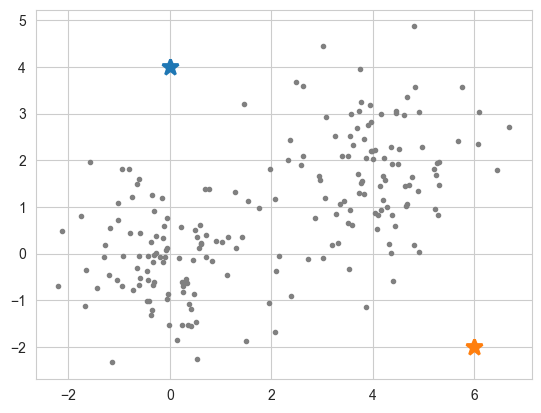

In [8]:
fig, ax = plt.subplots()
ax.plot(x, y, ".", color="gray")
for cluster in clusters:
    ax.plot(cluster[0], cluster[1], "*", mew=2, ms=12)

Now, we need to assign each point to the nearest cluster center. To do so, we will first need to decide on the distance metric. In this case, we will use the Euclidean distance.

In [9]:
def euclidean_distance(v1, v2):
    return np.sqrt(sum((v1[i] - v2[i]) ** 2 for i in range(len(v1))))

In [10]:
iterations = 0

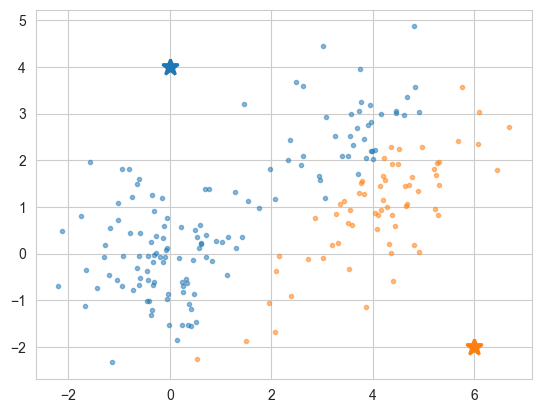

In [11]:
best_matches = [[] for i in range(k)]  # cluster assignments
# Find which centroid is the closest for each row
for j, row in enumerate(rows):
    best_match = 0
    for i in range(k):
        d = euclidean_distance(clusters[i], row)
        if d < euclidean_distance(clusters[best_match], row):
            best_match = i
    best_matches[best_match].append(j)
fig, ax = plt.subplots()
for i in range(k):
    ax.plot(
        [rows[j][0] for j in best_matches[i]],
        [rows[j][1] for j in best_matches[i]],
        ".",
        alpha=0.5,
    )
for i, cluster in enumerate(clusters):
    ax.plot(cluster[0], cluster[1], "*", mew=2, ms=12, color=f"C{i}")

OK, so we have the point assignments, now we will update the cluster centers.

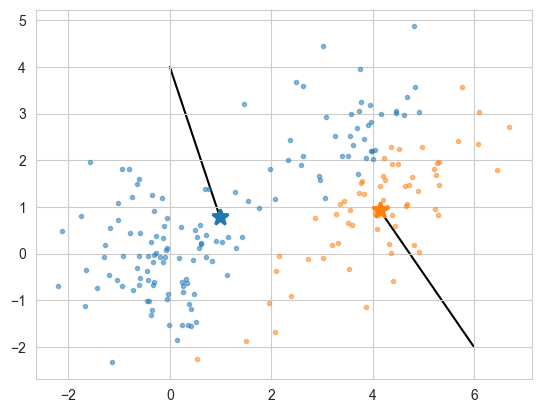

In [12]:
old_clusters = np.copy(clusters)
for i in range(k):
    if best_matches[i]:
        avg = np.mean([rows[row_id] for row_id in best_matches[i]], axis=0)
        clusters[i] = avg.tolist()
fig, ax = plt.subplots()
for i in range(k):
    ax.plot(
        [rows[j][0] for j in best_matches[i]],
        [rows[j][1] for j in best_matches[i]],
        ".",
        alpha=0.5,
    )
for i, cluster in enumerate(clusters):
    ax.plot(cluster[0], cluster[1], "*", mew=2, ms=12, color=f"C{i}")
    ax.plot(
        [old_clusters[i][0], cluster[0]],
        [old_clusters[i][1], cluster[1]],
        "k-",
        zorder=-1,
    )

In [13]:
# Let's repeat the process until convergence

Iteration 000. Number of points in cluster 0: 135, cluster 1: 65
Iteration 001. Number of points in cluster 0: 105, cluster 1: 95
Iteration 002. Number of points in cluster 0: 100, cluster 1: 100


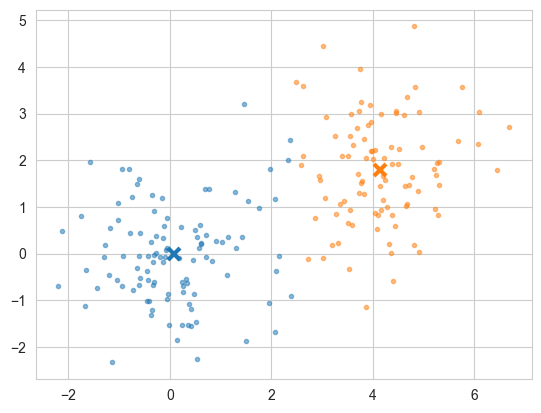

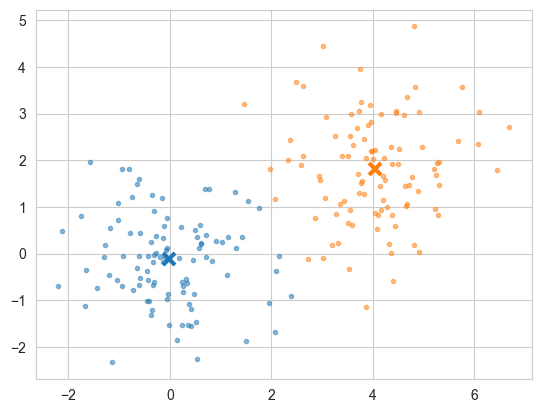

In [14]:
last_matches = None
for t in range(100):
    print(
        f"Iteration {t:03d}. Number of points in cluster 0: {len(best_matches[0])}, cluster 1: {len(best_matches[1])}"
    )
    best_matches = [[] for i in range(k)]
    # Find which centroid is the closest for each row
    for j, row in enumerate(rows):
        best_match = 0
        for i in range(k):
            d = euclidean_distance(clusters[i], row)
            if d < euclidean_distance(clusters[best_match], row):
                best_match = i
        best_matches[best_match].append(j)
    # If the results are the same as last time, this is complete
    if best_matches == last_matches:
        break
    last_matches = best_matches
    # Move the centroids to the average of their members
    for i in range(k):
        if best_matches[i]:
            avg = np.mean([rows[row_id] for row_id in best_matches[i]], axis=0)
            clusters[i] = avg.tolist()
    fig, ax = plt.subplots()
    for i in range(k):
        ax.plot(
            [rows[j][0] for j in best_matches[i]],
            [rows[j][1] for j in best_matches[i]],
            ".",
            alpha=0.5,
        )
    for i, cluster in enumerate(clusters):
        ax.plot(cluster[0], cluster[1], "x", mew=3, ms=8, color=f"C{i}")

In [15]:
import numpy as np
from typing import List, Callable, Tuple


def k_means(
    rows: List[List[float]],
    k: int,
    distance: Callable[[List[float], List[float]], float],
) -> Tuple[List[List[float]], List[List[int]]]:
    """
    Performs K-means clustering on the given dataset.

    Args:
        rows (List[List[float]]): The dataset, where each element is a list of features for one data point.
        k (int): The number of clusters to form.
        distance (Callable[[List[float], List[float]], float]): A function to compute the distance between two data points.

    Returns:
        Tuple[List[List[float]], List[List[int]]]: A tuple containing the final centroids and the assignment of data points to clusters.
    """
    ranges = [
        (min([row[i] for row in rows]), max([row[i] for row in rows]))
        for i in range(len(rows[0]))
    ]
    clusters = [
        [
            np.random.random() * (ranges[i][1] - ranges[i][0]) + ranges[i][0]
            for i in range(len(rows[0]))
        ]
        for j in range(k)
    ]

    last_matches = None
    for t in range(100):
        best_matches = [[] for i in range(k)]

        # Find which centroid is the closest for each row
        for j, row in enumerate(rows):
            best_match = 0
            for i in range(k):
                d = distance(clusters[i], row)
                if d < distance(clusters[best_match], row):
                    best_match = i
            best_matches[best_match].append(j)

        # If the results are the same as last time, this is complete
        if best_matches == last_matches:
            break
        last_matches = best_matches

        # Move the centroids to the average of their members
        for i in range(k):
            if best_matches[i]:
                avg = np.mean([rows[row_id] for row_id in best_matches[i]], axis=0)
                clusters[i] = avg.tolist()

    return clusters, best_matches

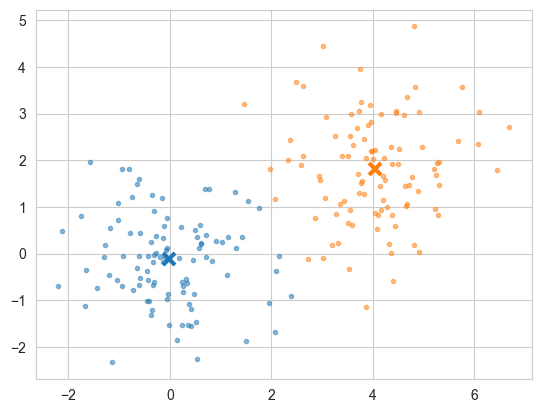

In [16]:
clusters, best_matches = k_means(rows, 2, euclidean_distance)
fig, ax = plt.subplots()
for i in range(k):
    ax.plot(
        [rows[j][0] for j in best_matches[i]],
        [rows[j][1] for j in best_matches[i]],
        ".",
        alpha=0.5,
    )
for i, cluster in enumerate(clusters):
    ax.plot(cluster[0], cluster[1], "x", mew=3, ms=8, color=f"C{i}")

Unsupervised learning assumes that the ground truth isn't known. However, in this synthetic example, we know that the data is composed of two clusters. We also know the true centroids. Let's compare the true centroids with the centroids we found.

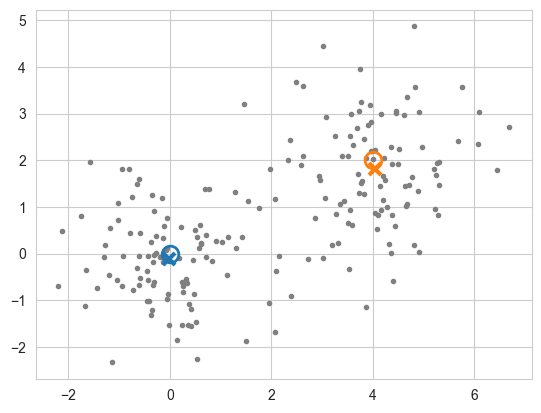

In [17]:
fig, ax = plt.subplots()
ax.plot(x, y, ".", color="gray")
for i, cluster in enumerate(clusters):
    ax.plot(cluster[0], cluster[1], "x", mew=3, ms=8, color=f"C{i}")
ax.plot(true_center_1[0], true_center_1[1], "o", mew=2, ms=12, mec=f"C{0}", mfc="none")
ax.plot(true_center_2[0], true_center_2[1], "o", mew=2, ms=12, mec=f"C{1}", mfc="none")

Like we said, before running the clustering, we need to decide how we compute the distance between two points. In the example above, we used the Euclidean distance. Let's try the [Manhattan distance now](https://en.wikipedia.org/wiki/Taxicab_geometry).

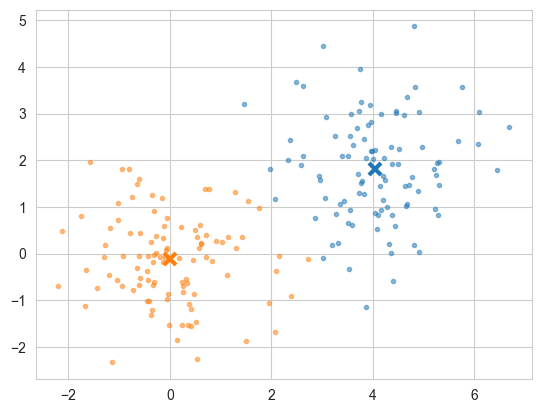

In [18]:
def manhattan_distance(v1, v2):
    return sum(abs(v1[i] - v2[i]) for i in range(len(v1)))


clusters, best_matches = k_means(rows, 2, manhattan_distance)
fig, ax = plt.subplots()
for i in range(k):
    ax.plot(
        [rows[j][0] for j in best_matches[i]],
        [rows[j][1] for j in best_matches[i]],
        ".",
        alpha=0.5,
    )
for i, cluster in enumerate(clusters):
    ax.plot(cluster[0], cluster[1], "x", mew=3, ms=8, color=f"C{i}")

Cosine distance

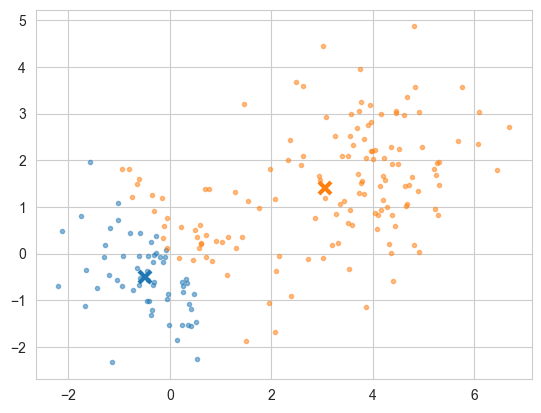

In [19]:
def cosine_distance(v1, v2):
    return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


clusters, best_matches = k_means(rows, 2, cosine_distance)
fig, ax = plt.subplots()
for i in range(k):
    ax.plot(
        [rows[j][0] for j in best_matches[i]],
        [rows[j][1] for j in best_matches[i]],
        ".",
        alpha=0.5,
    )
for i, cluster in enumerate(clusters):
    ax.plot(cluster[0], cluster[1], "x", mew=3, ms=8, color=f"C{i}")

The fact that you can use a certain distance metric doesn't mean you **should** use it. The choice of the distance metric is crucial and can make or break your clustering. In the example above, the Manhattan distance can be a good choice if the data points represent instances on a grid that can only be accessed by traveling along the grid. I can't think of a valid reason to use the cosine distance in this case, but it's a good example to show that you can use it.

Of course, we are not savages and don't have to implement K-means from scratch every time we need to use it. There are many libraries that implement it, such as `scikit-learn` which provides very efficient implementations of many machine learning algorithms. 

In [20]:
import sklearn.cluster

[a for a in dir(sklearn.cluster) if isinstance(getattr(sklearn.cluster, a), type)]

['AffinityPropagation',
 'AgglomerativeClustering',
 'Birch',
 'BisectingKMeans',
 'DBSCAN',
 'FeatureAgglomeration',
 'HDBSCAN',
 'KMeans',
 'MeanShift',
 'MiniBatchKMeans',
 'OPTICS',
 'SpectralBiclustering',
 'SpectralClustering',
 'SpectralCoclustering']

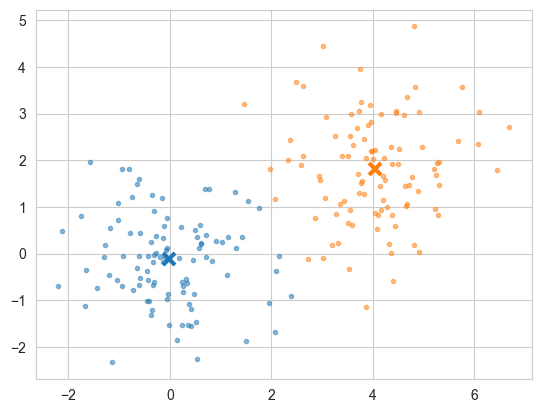

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(rows)

fig, ax = plt.subplots()
for i in range(kmeans.n_clusters):
    ax.plot(
        [rows[j][0] for j in range(len(rows)) if kmeans.labels_[j] == i],
        [rows[j][1] for j in range(len(rows)) if kmeans.labels_[j] == i],
        ".",
        alpha=0.5,
    )
for i, cluster in enumerate(kmeans.cluster_centers_):
    ax.plot(cluster[0], cluster[1], "x", mew=3, ms=8, color=f"C{i}")

The only problem with sklearn's KMeans is that it does not allow us to easily switch the distance metric. The library [NLTK](https://www.nltk.org/) is a natural language processing library that provides a KMeans implementation that allows us to switch the distance metric. We will not use it in this example, but it's good to know that it exists.

## Number of clusters

How do we decide the number of clusters? In the example above, we knew that the data was composed of two clusters. In real-world scenarios, we don't know the number of clusters. There are many methods to determine the number of clusters, such as the elbow method, the silhouette score, etc. We will use the elbow method as an example.

The central concept in this method is within-cluster sum of squares (WCSS). This metric measures the compactness of the clusters. The idea is to plot the WCSS against the number of clusters. The point where the curve starts to flatten is the elbow point, which is the optimal number of clusters.

In [22]:
def compute_wcss(data: np.ndarray, kmeans: KMeans) -> float:
    """
    Compute the within-cluster sum of squares (WCSS) for a given KMeans model.

    Args:
        data (np.ndarray): The dataset.
        kmeans (KMeans): The KMeans model after fitting.

    Returns:
        float: The WCSS value.
    """
    wcss = 0.0
    for i in range(kmeans.n_clusters):
        cluster_points = data[kmeans.labels_ == i]
        centroid = kmeans.cluster_centers_[i]
        wcss += np.sum((cluster_points - centroid) ** 2)
    return wcss

Text(2.0, 394.580525930531, ' elbow point')

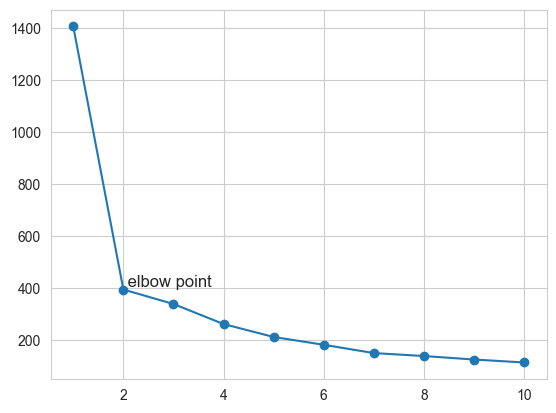

In [23]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rows)
    wcss.append((k, compute_wcss(rows, kmeans)))
wcss = np.array(wcss)
# Plot the WCSS values
fig, ax = plt.subplots()
ax.plot(wcss[:, 0], wcss[:, 1], marker="o")
ax.text(wcss[1, 0], wcss[1, 1], " elbow point", fontsize=12, verticalalignment="bottom")

In the two cells of code above, you saw attributes of the k-means object with a trailing underscore (`kmeans.cluster_centers_` and `kmeans.labels_`). In `sklearn` ecosystem, attributes with a trailing underscore are set after the model is fitted and provide additional information about the model. For example, `kmeans.cluster_centers_` contains the cluster centers after the model is fitted.

One such an additional attribute is `inertia_`, which is the WCSS. The code below is equivalent to the code above.

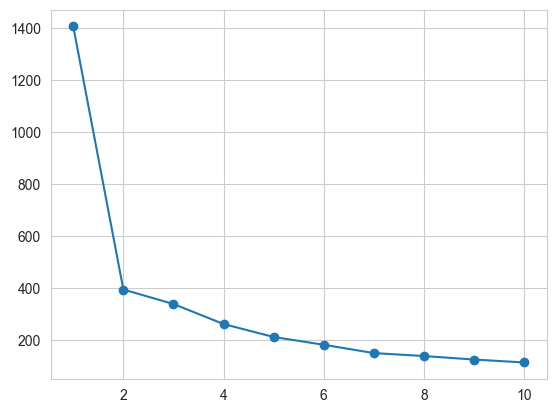

In [24]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rows)
    wcss.append((k, kmeans.inertia_))
wcss = np.array(wcss)
fig, ax = plt.subplots()
ax.plot(wcss[:, 0], wcss[:, 1], marker="o")

## Clustering real-life data
Let's now apply K-means clustering to the movie dataset we loaded at the beginning of this section.

In [25]:
df_movies.head()

,id,title,budget,revenue,runtime,popularity,vote_average
0,19995,Avatar,237000000,2787965087,162.0,150.437577,7.2
1,285,Pirates of the Caribbean: At World's End,300000000,961000000,169.0,139.082615,6.9
2,206647,Spectre,245000000,880674609,148.0,107.376788,6.3
3,49026,The Dark Knight Rises,250000000,1084939099,165.0,112.312950,7.6
4,49529,John Carter,260000000,284139100,132.0,43.926995,6.1


Recall the importance of distance metrics. By the nature of the Euclidian distance, the algorithm will be biased towards features with higher values. In our case, the budget and the revenue have the order of magnitude of millions, while the vote average is between 0 and 10. To avoid this bias, we will normalize the data. The standard way to do so is to subtract the mean and divide by the standard deviation. Additionally, we will transform the budget and revenue to log scale before normalization.

In [26]:
df_scaled = df_movies.drop(columns="id").set_index("title").copy()
df_scaled["budget"] = np.log1p(df_scaled["budget"])
df_scaled["revenue"] = np.log1p(df_scaled["revenue"])
for col in df_scaled.columns:
    df_scaled[col] = (df_scaled[col] - df_scaled[col].mean()) / df_scaled[col].std()
df_scaled.head()

,budget,revenue,runtime,popularity,vote_average
title,,,,,
Avatar,1.494556,2.048054,2.445692,3.356877,1.019174
Pirates of the Caribbean: At World's End,1.636403,1.535685,2.779571,3.042906,0.675882
Spectre,1.514533,1.493696,1.777934,2.166225,-0.010702
The Dark Knight Rises,1.526691,1.594039,2.588783,2.302712,1.476897
John Carter,1.550292,0.949514,1.014783,0.411807,-0.239564


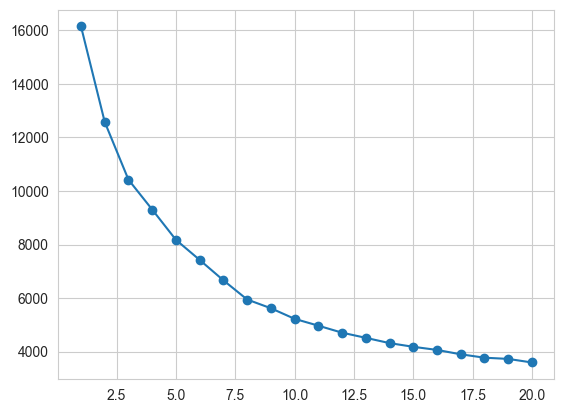

In [27]:
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append((k, kmeans.inertia_))
wcss = np.array(wcss)
fig, ax = plt.subplots()
ax.plot(wcss[:, 0], wcss[:, 1], marker="o")

Unsurprisingly, there is no clear elbow point in the plot above. This is an indication that the clustering movies using the features we have is not expected to provide meaningful clusters. If we really need to cluster movies, we should use more features, such as genres, keywords, etc.